In [3]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1D Heat Transfer ODE (aligned with Paolo's work)
### $C(r)\frac{\partial T(t)}{\partial{t}} = F(t) + \lambda(r) T(t)$,
where $C(r)$ is the heat capacity ($C = \rho_{\text{w}} \, c_{\text{w}} \, h(r)$, $\rho_{\text{w}} = 10^3$, $c_{\text{w}} = 4 \times 10^3$), $T(t)$ is the temperature, $F(t)$ is the effective radiative forcing, and $\lambda(r)$ is the local feedback parameter; $r$ denotes the region.

This relationship represents warming due to effective radiative forcing (ERF). This problem in 1D assumes that we are averaging over a few locations (e.g. land, Southern Ocean, and Arctic). The parameters of interest are given by:

| Parameter                                        | Symbol       | Fast  | Intermediate | Slow  |
|--------------------------------------------------|--------------|-------|--------------|-------|
| Effective water depth (m)                        | $h(r)$       | 10    | 150          | 1500  |
| Local Feedback (W m<sup>-2</sup> K<sup>-1</sup>) | $\lambda(r)$ | -0.86 | -2.0         | -0.67 |

We consider the following forcing profiles of interest:

| Forcing Type | Functional Form           | Value(s)                              |
|--------------|---------------------------|---------------------------------------|
| Constant     | $F$                       | 3.7, 7.4                              |
| Exponential  | $a e^{t/t^*}$             | $a = F_{\text{final}} / e^{250/t^*}$  |
| Overshoot    | $a e^{\frac{-(t - b)^2}{2c^2}}$ | $a = 4$, $b = 200$, $c = 42.7$        |

where $F_{\text{final}}$ is the radiative forcing at the end of the simulation (e.g. 7 W m<sup>-2</sup> K<sup>-1</sup> for SSP370) and $t^*$ is 50 years.


In [4]:
# Grid parameters
dt = 1
Nt = 250 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
rho_w = 1e3
c_w = 4e3
h = np.array([10.0, 150.0, 1500.0])
C = rho_w*c_w*h/3.154e7 # convert from seconds to years
lam = np.array([-0.86, -2.0, -0.67])

# Forcing parameters
F_2xCO2 = response_utils.F_const(t, 3.7)
F_4xCO2 = response_utils.F_const(t, 7.4)
F_final = 7 # (W m^-2)
ts = 50
a = F_final/np.exp(250*dt/ts)
T0 = 0 # K
F_exp = response_utils.F_exp(t, a, ts)
F0 = 1


In [5]:
T_2xCO2 = np.zeros((len(lam), len(t)))
g_2xCO2, a_2xCO2 = np.zeros((len(lam), 1)), np.zeros((len(lam), len(t)))
T_4xCO2 = np.zeros((len(lam), len(t)))
g_4xCO2, a_4xCO2 = np.zeros((len(lam), 1)), np.zeros((len(lam), len(t)))
T_exp = np.zeros((len(lam), len(t)))
g_exp, a_exp = np.zeros((len(lam), 1)), np.zeros((len(lam), len(t)))

# Analytic temperature profiles and modal decompositions
for i in range(len(T_2xCO2)):
  T_2xCO2[i] = response_utils.T_const(t, T0, lam[i], F_2xCO2, C[i])
  g_2xCO2[i], a_2xCO2[i] = response_utils.calc_modes_1D(T_2xCO2[i], t)
  T_4xCO2[i] = response_utils.T_const(t, T0, lam[i], F_4xCO2, C[i])
  g_4xCO2[i], a_4xCO2[i] = response_utils.calc_modes_1D(T_4xCO2[i], t)
  T_exp[i] = response_utils.T_exp(t, ts, a, T0, lam[i], C[i])
  g_exp[i], a_exp[i] = response_utils.calc_modes_1D(T_exp[i], t)


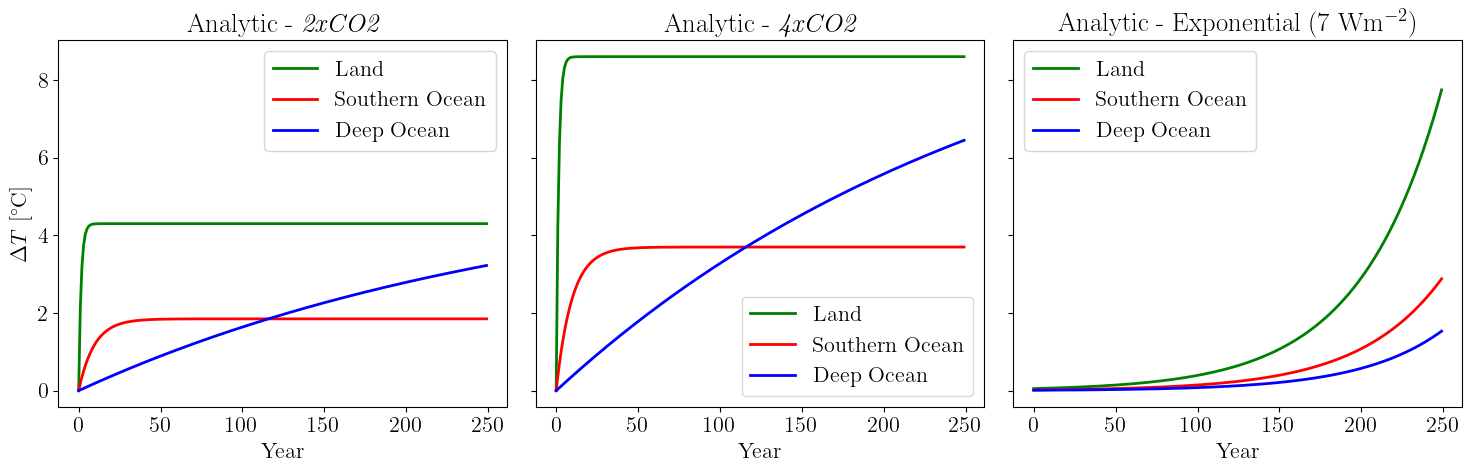

In [6]:
regions = ['Land', 'Southern Ocean', 'Deep Ocean']
colors = ['g','r','b']

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for i in range(len(regions)):
  ax[0].plot(T_2xCO2[i], c=colors[i], label=regions[i], lw=2)
  ax[1].plot(T_4xCO2[i], c=colors[i], label=regions[i], lw=2)
  ax[2].plot(T_exp[i], c=colors[i], label=regions[i], lw=2)

ax[0].set_title(r'Analytic - \textit{2xCO2}')
ax[1].set_title(r'Analytic - \textit{4xCO2}')
ax[2].set_title(r'Analytic - Exponential (7 Wm$^{-2}$)')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[2].set_xlabel('Year')
ax[0].set_ylabel(r'$\Delta T$ [$^\circ$C]')
ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()


#### Method 1: Direct inference of L from a dataset

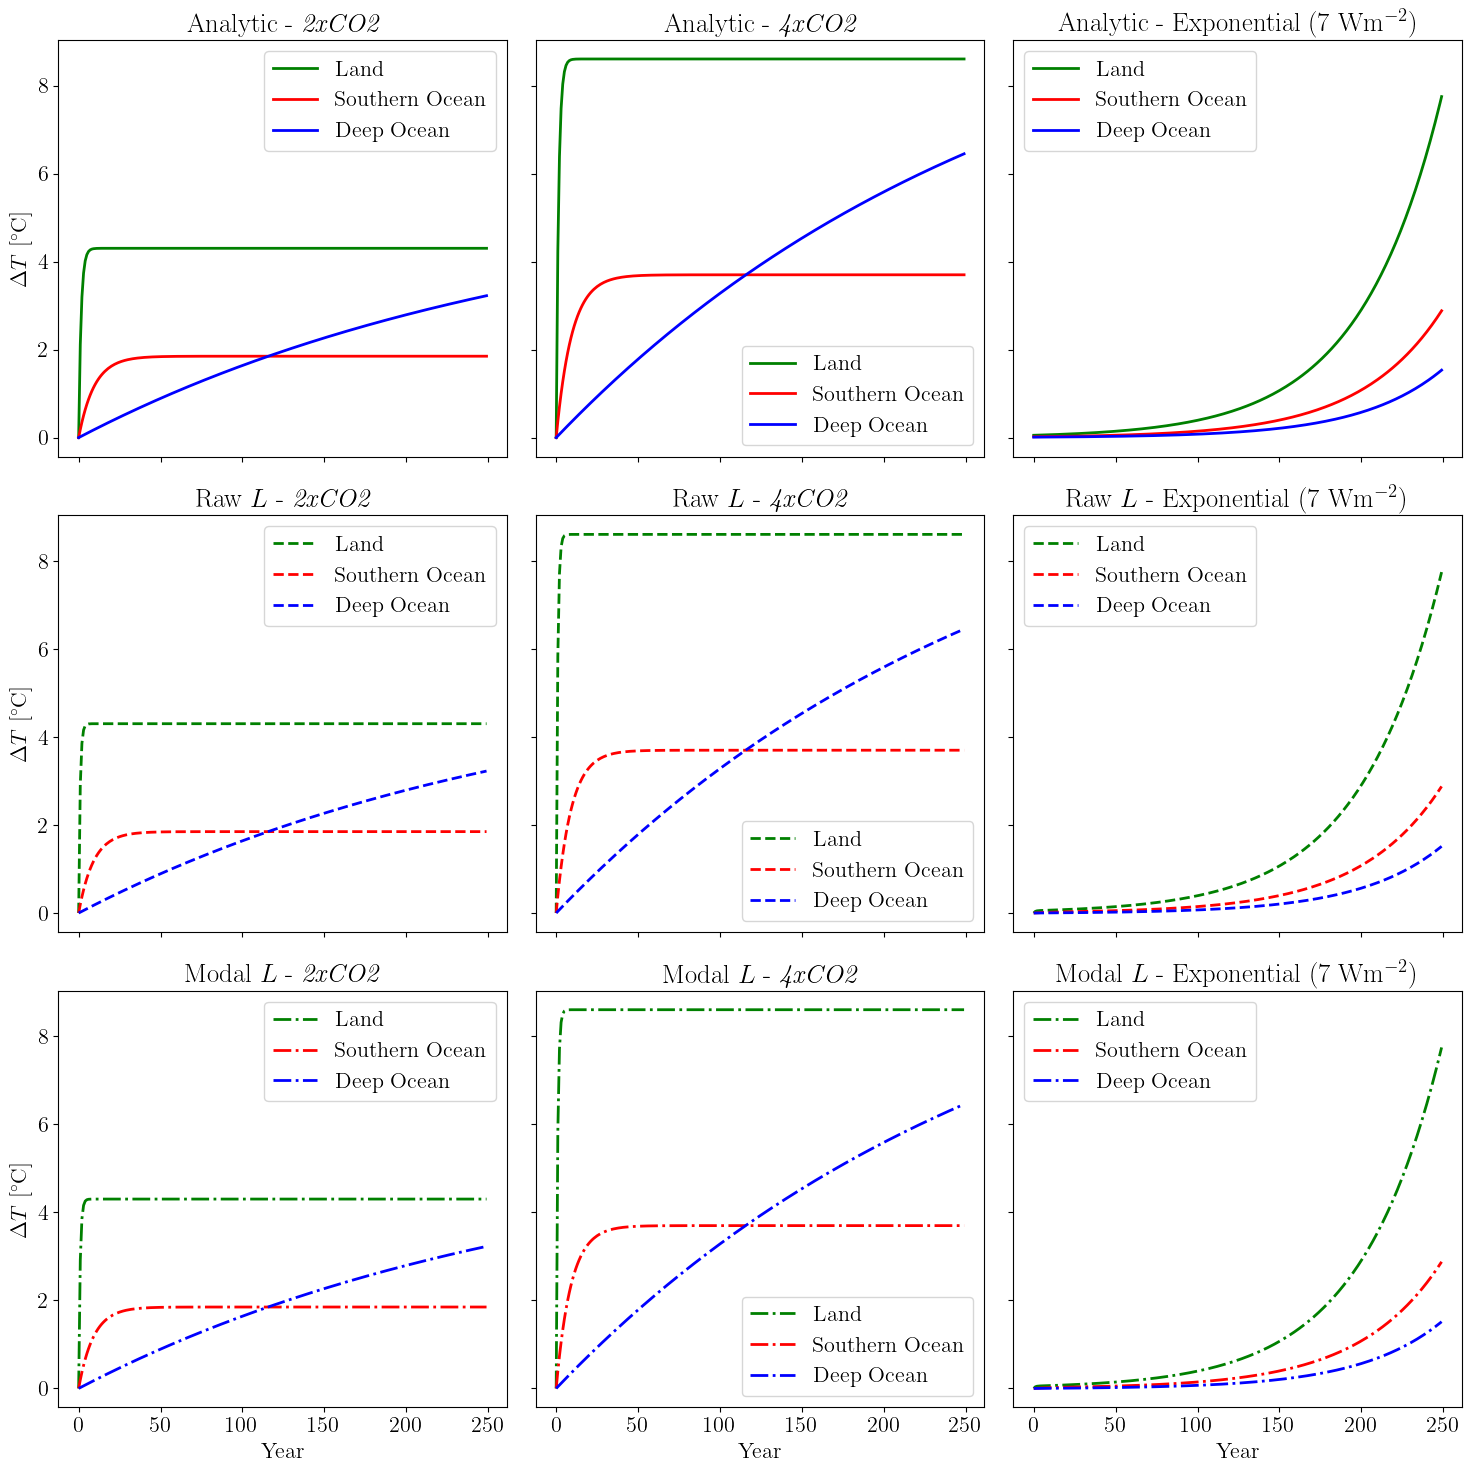

In [7]:
T_vec = [T_2xCO2, T_4xCO2, T_exp]
F_vec = [F_2xCO2, F_4xCO2, F_exp]
labels = ['a','b','c']

L_raw_2xCO2, L_modal_2xCO2 = {}, {}
L_raw_4xCO2, L_modal_4xCO2 = {}, {}
L_raw_exp, L_modal_exp = {}, {}

t_check = np.arange(0,250,1)

# Calculate L
for i in range(len(regions)):
  L_raw_2xCO2[i] = response_utils.calc_L_direct_1D_C(T_2xCO2[i], F_2xCO2, t, C[i])
  L_modal_2xCO2[i] = response_utils.calc_L_direct_1D_C(a_2xCO2[i], F_2xCO2, t, C[i], modal=True, g=g_2xCO2[i])
  L_raw_4xCO2[i] = response_utils.calc_L_direct_1D_C(T_4xCO2[i], F_4xCO2, t, C[i])
  L_modal_4xCO2[i] = response_utils.calc_L_direct_1D_C(a_4xCO2[i], F_4xCO2, t, C[i], modal=True, g=g_4xCO2[i])
  L_raw_exp[i] = response_utils.calc_L_direct_1D_C(T_exp[i], F_exp, t, C[i])
  L_modal_exp[i] = response_utils.calc_L_direct_1D_C(a_exp[i], F_exp, t, C[i], modal=True, g=g_exp[i])

L_raw_vec = [L_raw_2xCO2]
L_modal_vec = [L_modal_2xCO2]
response_utils.plot_response_1D_region_C(T_vec, F_vec, regions, t, C, L_raw_exp, L_modal_4xCO2, T0, dt=1)
#L2_raw, L2_modal = response_utils.plot_response_1D(T_vec, F_vec, labels, t, L_raw, L_modal, T0, dt)

### Method 2: Direct derivation of response functions using an impulse forcing

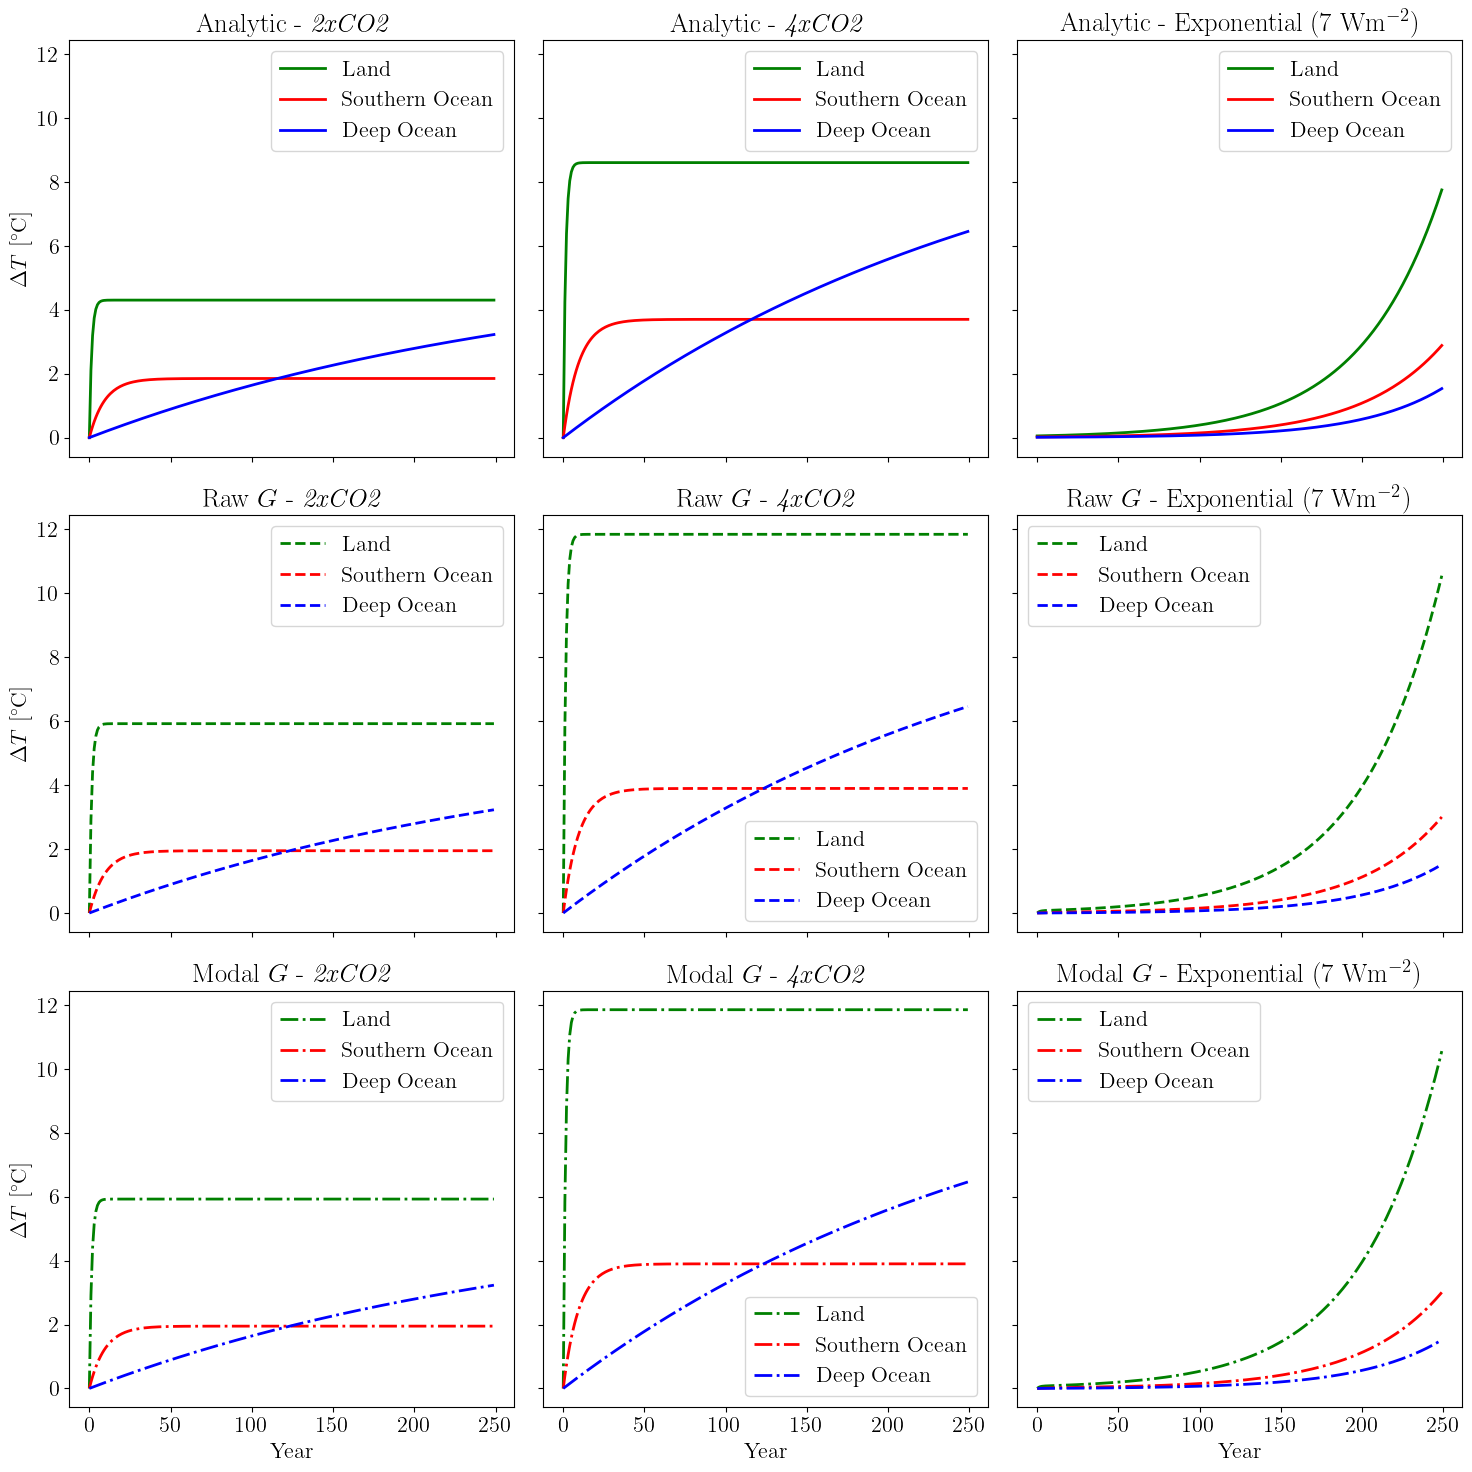

In [68]:
G_raw_2, g_2, G_modal_2 = {}, {}, {}

# Calculate G
for i in range(len(regions)):
  G_raw_2[i] = response_utils.T_del(t, lam[i], F0, C[i], dt)
  g_2[i], G_modal_2[i] = response_utils.calc_modes_1D(G_raw_2[i], t)

response_utils.plot_response_1D_conv_region(T_vec, F_vec, regions, t, G_raw_2, G_modal_2, g_2, 1)

### Method 3: Derivation through deconvolution

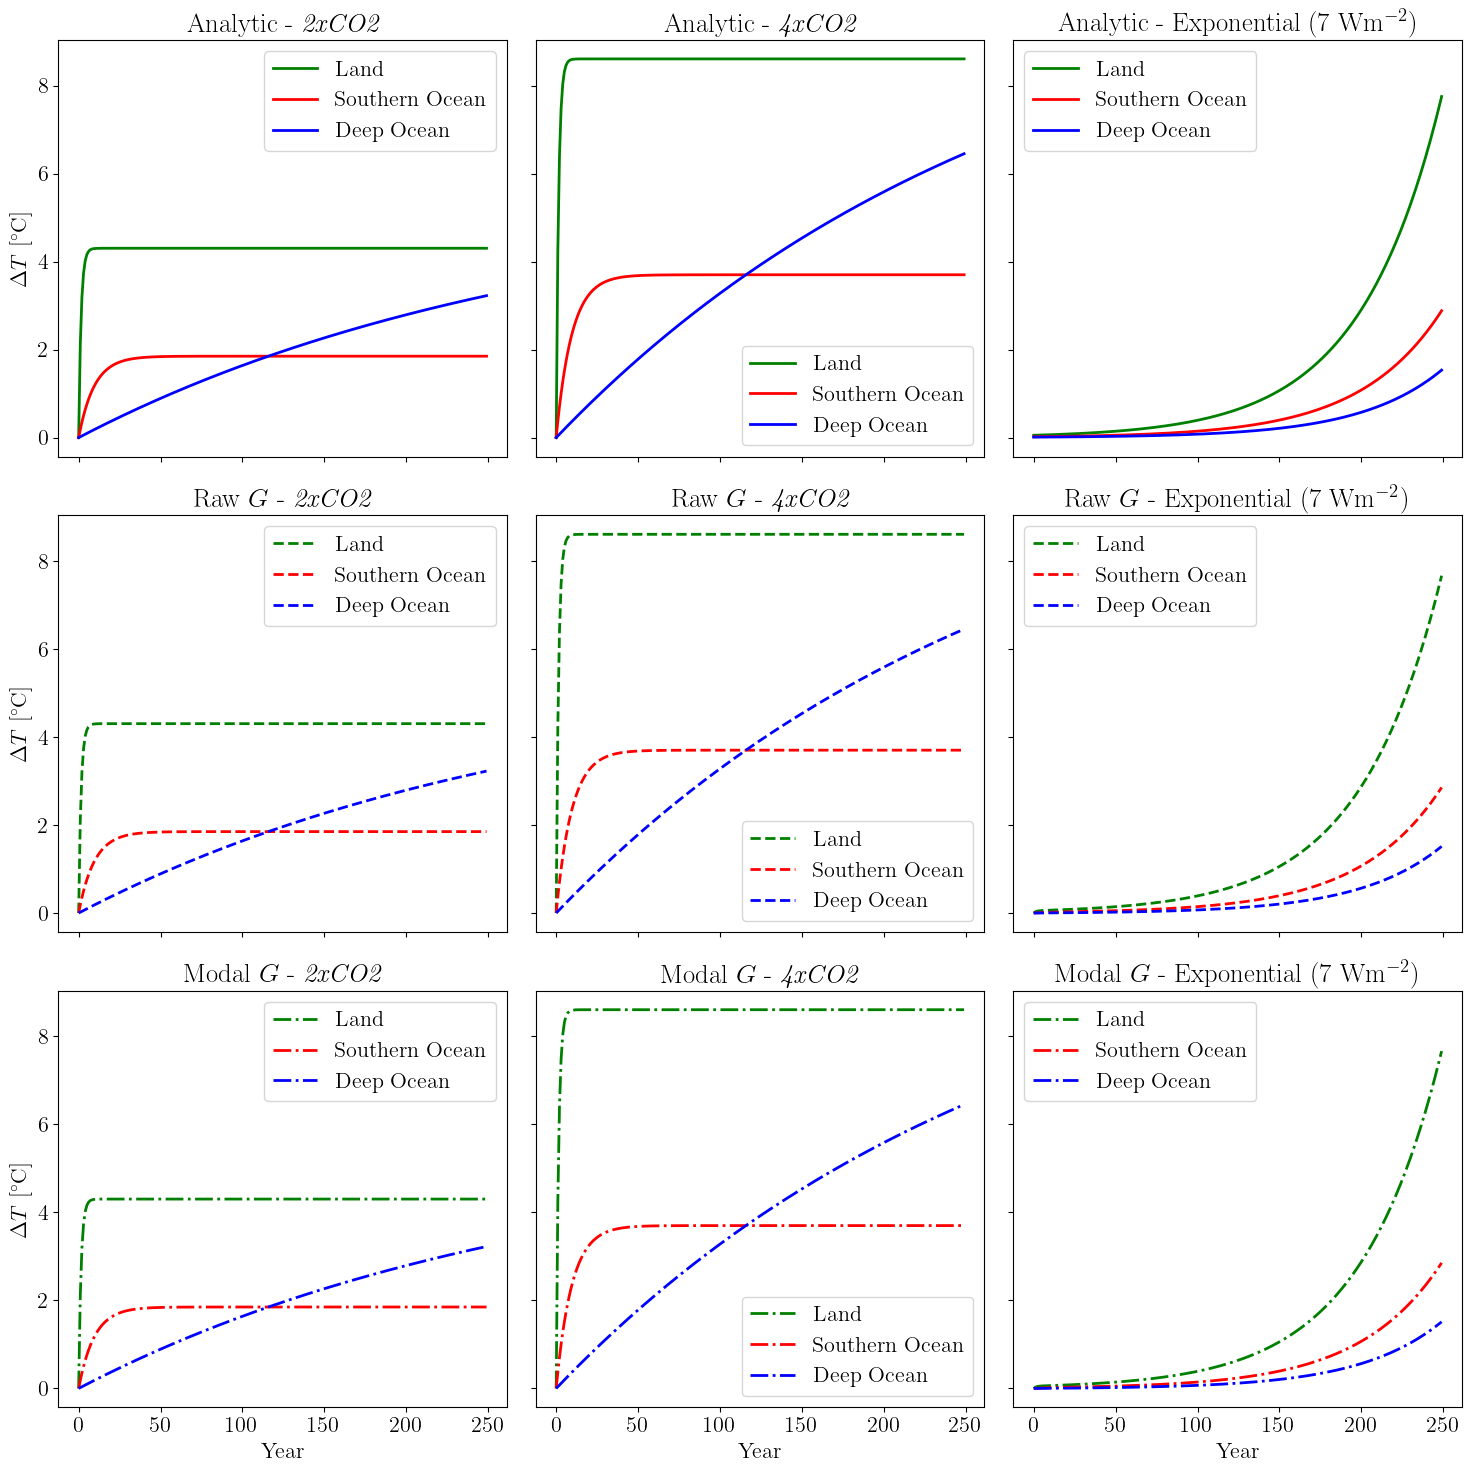

In [69]:
G_raw_3, g_3, G_modal_3 = {}, {}, {}

# Calculate G
for i in range(len(regions)):
  G_raw_3[i] = response_utils.calc_G_deconv_1D(T_2xCO2[i], F_2xCO2, dt=1)
  g_3[i], G_modal_3[i] = response_utils.calc_modes_1D(G_raw_3[i], t)

response_utils.plot_response_1D_conv_region(T_vec, F_vec, regions, t, G_raw_3, G_modal_3, g_3, dt=1)

### Method 4: Representing G with only leading timescales
Note that you need to flip the signs of $a(m,t)$ and $g(x,t)$ in this case, otherwise the exponential fit won't work.

[0.57258585 0.67810846] [0.57258586 0.67810847]
[0.04989688 0.10513138] [0.04989682 0.1051312 ]
[0.00524744 0.00352201] [0.00524743 0.00352199]


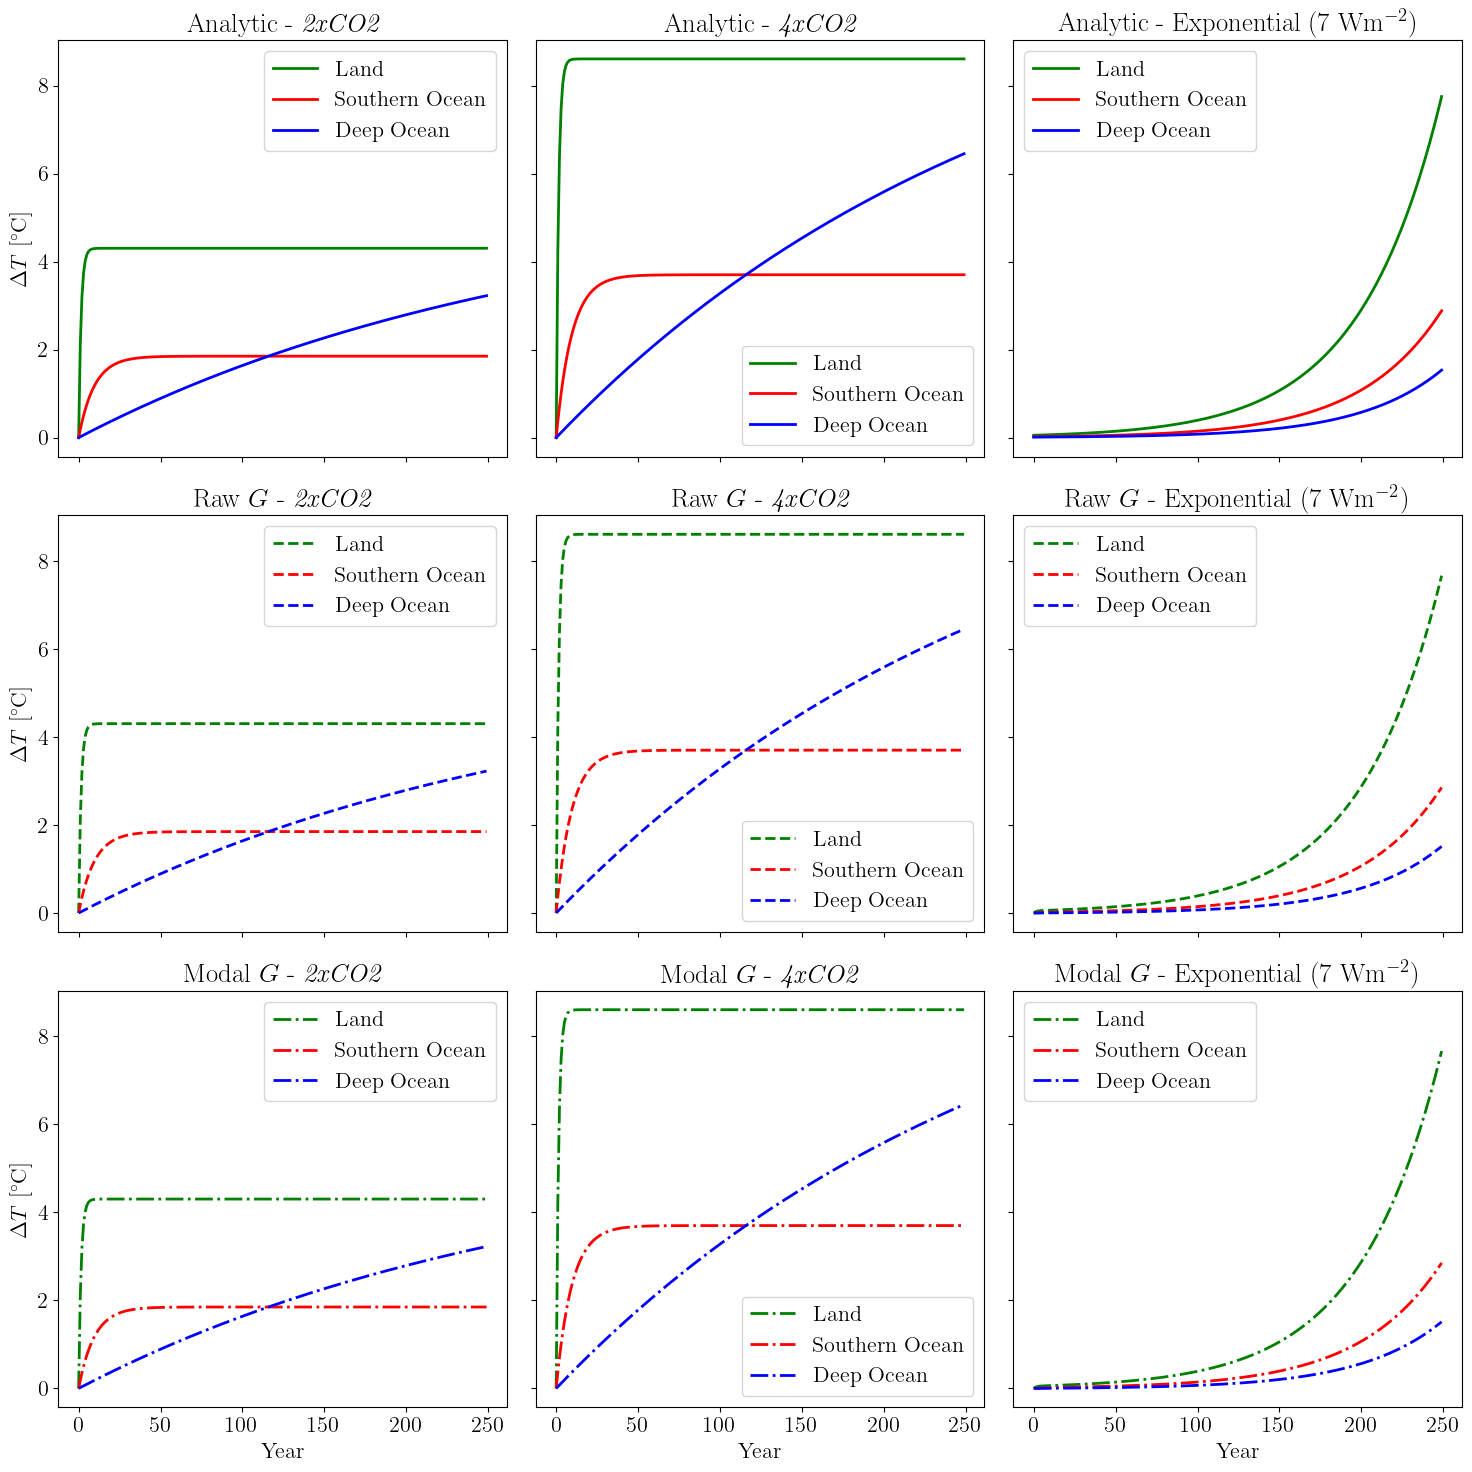

In [124]:
initial_guess = np.array([1, 1])
options = {'disp': False}

res_raw, res_modal = {}, {}
G_raw_4, G_modal_4 = {}, {}

for i in range(len(regions)):
  res_raw[i] = minimize(response_utils.opt_h_lam_1D,
                initial_guess,
                args=(T_2xCO2[i], F_2xCO2, t, 1),
                options=options)
  res_modal[i] = minimize(response_utils.opt_h_lam_1D,
                      initial_guess,
                      args=(a_2xCO2[i], F_2xCO2, t, 1, True),
                      options=options)

  G_raw_4[i] = response_utils.apply_response_1D(res_raw[i].x, t)
  G_modal_4[i] = response_utils.apply_response_1D(res_modal[i].x, t)
  print(res_raw[i].x, res_modal[i].x)

response_utils.plot_response_1D_conv_region(T_vec, F_vec, regions, t, G_raw_4, G_modal_4, g_2xCO2, dt=1, check=False)
#L2_raw, L2_modal = response_utils.plot_response_conv_1D(T_vec, F_vec, labels, t, G_opt_raw, G_opt_modal, -g_const_sub, dt)
